# **fGraph 0 detection with Decision Trees and SVM from eigenvalues**


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [1]:
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib
#!pip install xgboost

To import the libraries that will be used in this lab, execute the cells below. 


In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

## Load the dataset




In [24]:
# load the dataset
path= "COEFFICIENT_DEN_7.csv"
# read the input data
coefDen = pd.read_csv(path)
coefDen


,COEFFICIENT_DEN
0,1
1,1
2,1
3,1
4,1
...,...
215,0
216,0
217,0
218,0


In [62]:
# load the dataset
path= "eigenvalues_graph7.pkl"
# read the input data
eigen = pd.read_pickle(path)
# remove column coefficients
eigen = eigen.drop(columns=['COEFFICIENTS'])
# remove fGraph eigenvalues
eigen = eigen.iloc[:,1:12]

In [13]:
# load the dataset
path= "graph_walks_7.csv"
# read the input data
walks = pd.read_csv(path)
# remove column coefficients
walks = walks.drop(columns=['COEFFICIENTS'])
#remove all columns FGRAPH
for i in range(2, 12):
    walks = walks.drop(columns=['FGRAPH_WALKS' + str(i)])
walks

,DEN_WALKS2,DEN_WALKS3,DEN_WALKS4,DEN_WALKS5,DEN_WALKS6,DEN_WALKS7,DEN_WALKS8,DEN_WALKS9,DEN_WALKS10,DEN_WALKS11
0,27,54,357,1460,7611,36358,181797,894132,4435867,21936310
1,27,54,357,1460,7611,36358,181797,894132,4435867,21936310
2,27,54,357,1460,7611,36358,181797,894132,4435867,21936310
3,27,54,357,1460,7611,36358,181797,894132,4435867,21936310
4,27,54,357,1460,7611,36358,181797,894132,4435867,21936310
...,...,...,...,...,...,...,...,...,...,...
215,25,42,301,1065,5500,23877,114305,523230,2458065,11409761
216,26,48,370,1380,7682,34804,178306,855660,4273826,20884292
217,24,36,268,860,4356,17640,81300,352656,1586964,7023852
218,25,42,315,1035,5551,22743,110847,490704,2316320,10548802


In [15]:
# load the dataset
path= "graph_cycles_7.csv"
# read the input data
cycles = pd.read_csv(path)
cycles

,CYCLES_MULT3,CYCLES_MULT4,CYCLES_MULT5,CYCLES_MULT6,CYCLES_MULT7,CYCLES_MULT8,CYCLES_MULT9,CYCLES_MULT10,CYCLES_MULT11
0,18,29,78,234,566,1018,1322,1152,508
1,18,29,78,234,566,1018,1322,1152,508
2,18,29,78,234,566,1018,1322,1152,508
3,18,29,78,234,566,1018,1322,1152,508
4,18,29,78,234,566,1018,1322,1152,508
...,...,...,...,...,...,...,...,...,...
215,14,23,57,134,260,415,520,441,178
216,16,34,86,175,296,414,488,406,156
217,12,19,48,94,160,243,308,259,102
218,14,27,57,107,208,369,507,453,183


In [18]:
# load the dataset
path= "connectivity_7.csv"
# read the input data
connectivity = pd.read_csv(path)
connectivity

,CONNECTIVITY
0,4
1,4
2,4
3,4
4,4
...,...
215,4
216,3
217,3
218,3


In [17]:
# load the dataset
path= "double_triangles_number_7.csv"
# read the input data
double_triangles = pd.read_csv(path)
double_triangles


,DOUBLE_TRIANGLES
0,18
1,18
2,18
3,18
4,18
...,...
215,5
216,9
217,5
218,9


In [66]:
#concatenate the columns of the dataframes
raw_data = pd.concat([coefDen,eigen,walks, cycles, connectivity, double_triangles], axis=1)
raw_data

,COEFFICIENT_DEN,EV_DEN1,EV_DEN2,EV_DEN3,EV_DEN4,EV_DEN5,EV_DEN6,EV_DEN7,EV_DEN8,EV_DEN9,...,CYCLES_MULT4,CYCLES_MULT5,CYCLES_MULT6,CYCLES_MULT7,CYCLES_MULT8,CYCLES_MULT9,CYCLES_MULT10,CYCLES_MULT11,CONNECTIVITY,DOUBLE_TRIANGLES
0,1,-2.2258,-1.7321,-1.7321,-1.000,-1.0000,-0.7259,1.7321,1.7321,2.2361,...,29,78,234,566,1018,1322,1152,508,4,18
1,1,-2.2258,-1.7321,-1.7321,-1.000,-1.0000,-0.7259,1.7321,1.7321,2.2361,...,29,78,234,566,1018,1322,1152,508,4,18
2,1,-2.2258,-1.7321,-1.7321,-1.000,-1.0000,-0.7259,1.7321,1.7321,2.2361,...,29,78,234,566,1018,1322,1152,508,4,18
3,1,-2.2258,-1.7321,-1.7321,-1.000,-1.0000,-0.7259,1.7321,1.7321,2.2361,...,29,78,234,566,1018,1322,1152,508,4,18
4,1,-2.2258,-1.7321,-1.7321,-1.000,-1.0000,-0.7259,1.7321,1.7321,2.2361,...,29,78,234,566,1018,1322,1152,508,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0,-2.1966,-1.7554,-1.6573,-1.000,-0.4816,-0.2213,1.1938,1.5071,2.4820,...,23,57,134,260,415,520,441,178,4,5
216,0,-2.0000,-1.7524,-1.5616,-1.000,-0.3074,-0.0000,1.0000,1.0362,2.5616,...,34,86,175,296,414,488,406,156,3,9
217,0,-2.2709,-2.0000,-1.4652,-1.000,-0.1802,0.0000,1.0000,1.2527,2.6636,...,19,48,94,160,243,308,259,102,3,5
218,0,-2.0000,-1.7457,-1.5456,-0.647,-0.4240,0.0000,0.3520,1.4172,2.8405,...,27,57,107,208,369,507,453,183,3,9


In [67]:
raw_data.to_csv('raw_data.csv', index=False)

## Study correlation matrix

<Axes: >

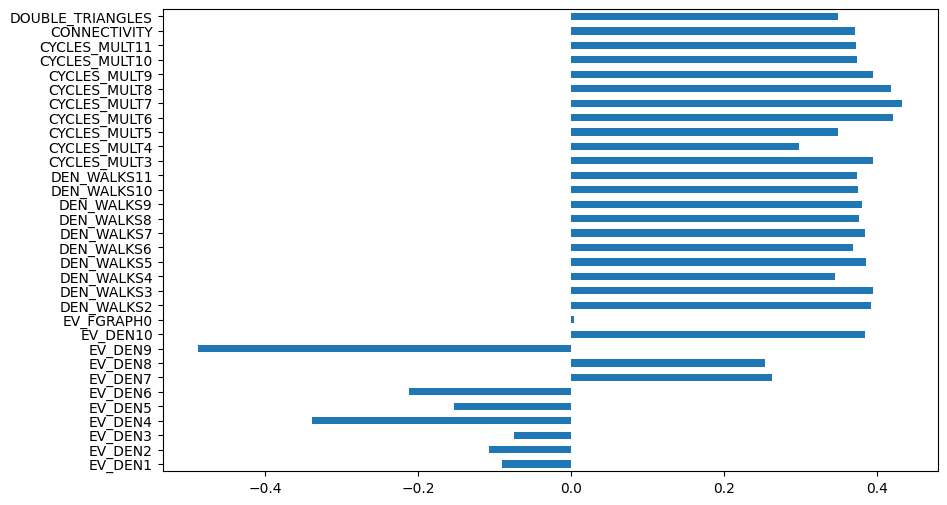

In [68]:
correlation_values = raw_data.corr()['COEFFICIENT_DEN'].drop('COEFFICIENT_DEN')
correlation_values.plot(kind='barh', figsize=(10, 6))

<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


Prepare the data for training. Apply standard scaling to the input features and normalize them using $L_1$ norm for the training models to converge quickly. COEFFICIENTS will be used as the target variable.


In [69]:
#Number of columns
col_num = len(raw_data.columns)
col_num

33

In [70]:
# standardize features by removing the mean and scaling to unit variance
raw_data.iloc[:, 1:col_num] = StandardScaler().fit_transform(raw_data.iloc[:, 1:col_num])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:col_num]

# y: labels vector
y = data_matrix[:, 0]

# data normalization
X = normalize(X, norm="l1")

/tmp/ipykernel_198266/901589209.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.31523604  1.31523604  1.31523604  1.31523604  1.31523604  1.31523604
  1.31523604  0.5332038   0.5332038   0.5332038   1.31523604  1.31523604
  0.5332038   0.5332038  -1.03086068  0.5332038  -0.24882844  1.31523604
  0.5332038  -1.03086068 -1.81289292 -0.24882844  0.5332038  -0.24882844
 -1.81289292 -1.03086068  1.31523604 -1.03086068 -0.24882844  1.31523604
  0.5332038  -0.24882844 -0.24882844 -0.24882844 -1.03086068 -0.24882844
 -1.03086068  1.31523604  1.31523604  0.5332038   0.5332038  -1.03086068
 -0.24882844 -0.24882844  1.31523604 -1.03086068  1.31523604  1.31523604
  1.31523604  0.5332038   0.5332038  -0.24882844 -0.24882844 -1.03086068
 -0.24882844  0.5332038   0.5332038   0.5332038   0.5332038  -1.03086068
 -1.03086068  1.31523604  1.31523604 -0.24882844 -0.24882844  0.5332038
  1.31523604  1.31523604  1.31523604  1.31

<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>


Divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<div id="dt_sklearn">
    <h2>Build a Decision Tree Classifier model with Scikit-Learn</h2>
</div>


Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset.


In [72]:
w_train = compute_sample_weight('balanced', y_train)

Using these sample weights, we may train the Decision Tree classifier. We also make note of the time it takes for training this model to compare it against SVM, later in the lab.


In [73]:
# for reproducible output across multiple function calls, set random_state to a given integer value
# Best depth is 5
dt = DecisionTreeClassifier(max_depth=5, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=5, random_state=35)

<div id="svm_sklearn">
    <h2>Build a Support Vector Machine model with Scikit-Learn</h2>
</div>


Unlike Decision Trees, we do not need to initiate a separate sample_weight for SVMs. We can simply pass a parameter in the scikit-learn function.


In [74]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

<div id="dt_sklearn_snapml">
    <h2>Evaluate the Decision Tree Classifier Models</h2>
</div>


Probabilities of the test coeffciente to be zero

In [75]:
y_pred_dt = dt.predict_proba(X_test)[:,1]

Using these probabilities, we can evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score as a metric of model performance. 
The AUC-ROC score evaluates your model's ability to distinguish positive and negative classes considering all possible probability thresholds. The higher its value, the better the model is considered for separating the two classes of values.


In [76]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.638


In [77]:
dt.score(X_test, y_test)

0.6818181818181818

<div id="svm_sklearn_snap">
    <h2>Evaluate the Support Vector Machine Models</h2>
</div>


Run the following cell to compute the probabilities of the test samples belonging to the class of fraudulent transactions. 


In [78]:
y_pred_svm = svm.decision_function(X_test)

You may now evaluate the accuracy of SVM on the test set in terms of the ROC-AUC score.


In [79]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.771


In [80]:
svm.score(X_test, y_test)

0.5909090909090909

## Random Forest and xgBoost

In [81]:
# Initialize models
n_estimators = 100
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
xgb = XGBRegressor(n_estimators=n_estimators, random_state=42)

In [82]:
# Fit models
# Measure training time for Random Forest
start_time_rf = time.time()
rf.fit(X_train, y_train)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf

# Measure training time for XGBoost
start_time_xgb = time.time()
xgb.fit(X_train, y_train)
end_time_xgb = time.time()
xgb_train_time = end_time_xgb - start_time_xgb

In [83]:
print(rf_train_time,xgb_train_time)

0.7336900234222412 0.20929288864135742


In [84]:
# Measure prediction time for Random Forest
start_time_rf = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - start_time_rf
print(rf_pred_time)

# Measure prediction time for XGBoost
start_time_xgb = time.time()
y_pred_xgb = xgb.predict(X_test)
xgb_pred_time = time.time() - start_time_rf
print(xgb_pred_time)

0.03699088096618652
0.06046128273010254


In [85]:
# accuracy metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test,y_pred_xgb)
r2_rf = r2_score(y_test,y_pred_rf)
r2_xgb = r2_score(y_test,y_pred_xgb)

In [86]:
mse_rf, mse_xgb

(0.09303181818181817, 0.10899095060788465)

In [87]:
r2_rf, r2_xgb

(0.4702658823529411, 0.3793927047739273)

In [88]:
def approximate(num):
    """
    Approximates a number between 0 and 1 to 0 or 1.
    
    Parameters:
    num (float): A number between 0 and 1.
    
    Returns:
    int: 0 if num is less than 0.5, otherwise 1.
    """
    return 0 if num < 0.5 else 1

In [89]:
diff = xgb.predict(X_test)- y_test
[ approximate(i) for i in abs(diff)].count(1) / len(diff) * 100

13.636363636363635

In [90]:
diff = rf.predict(X_test)- y_test
[ approximate(i) for i in abs(diff)].count(1) / len(diff) * 100

6.8181818181818175

In [91]:
[ approximate(i) for i in  rf.predict(X_test) - xgb.predict(X_test)].count(1)

0

# ChatGpt clasifier computation

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Load dataset
df = pd.read_csv("raw_data.csv")

# 2. Extract features and target
y = df["COEFFICIENT_DEN"]
X = df.drop(columns=["COEFFICIENT_DEN"])

# Optional: drop non-numeric columns or encode them
X = pd.get_dummies(X)  # encode categorical columns if any

# 3. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train a classifier (Logistic Regression here)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# 6. Predict and evaluate
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.89      1.00      0.94        16

    accuracy                           0.91        22
   macro avg       0.94      0.83      0.87        22
weighted avg       0.92      0.91      0.90        22



### most important feature

In [102]:
# 7. Get feature importance from Logistic Regression
feature_names = X.columns
coefficients = clf.coef_[0]  # For binary classification, it's a 1D array

# Create a DataFrame for sorting and readability
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Sort by absolute value of coefficients
feature_importance_sorted = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Display the most relevant feature
most_relevant = feature_importance_sorted.iloc[0:5]
print("Most relevant features:")
print(most_relevant)


Most relevant features:
         feature  coefficient  abs_coefficient
8        EV_DEN9    -1.034943         1.034943
2        EV_DEN3     0.647265         0.647265
4        EV_DEN5     0.635159         0.635159
20   DEN_WALKS11     0.561505         0.561505
27  CYCLES_MULT9     0.561389         0.561389


### Decision tree

In [103]:

# 4. (Optional) scale features – not needed for decision trees but harmless
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train a Decision Tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_scaled, y_train)

# 6. Predict and evaluate
y_pred = tree_clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8636363636363636
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.88      0.94      0.91        16

    accuracy                           0.86        22
   macro avg       0.84      0.80      0.82        22
weighted avg       0.86      0.86      0.86        22



In [ ]:
# 7. Feature importances from the decision tree
import numpy as np

importances = tree_clf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Most important features:")
print(feature_importance.iloc[0:4])

Most important feature:
          feature  importance
8         EV_DEN9    0.255279
29  CYCLES_MULT11    0.116850
6         EV_DEN7    0.104569
0         EV_DEN1    0.070307
